对X1~X4进行标准化处理

In [1]:
import pandas as pd
import numpy as np
# 读入基础数据
cemht = pd.read_csv("http://image.cador.cn/data/cemht.csv")
X = cemht.drop(columns=['No','Y'])
y = cemht.Y
# 对 X1~X4 进行标准化处理
X = X.apply(lambda x: (x - np.mean(x))/np.std(x),axis=1)
X.head()

,X1,X2,X3,X4
0,-0.812132,0.057192,-0.857886,1.612825
1,-1.234525,0.252215,-0.491155,1.473466
2,-0.666283,1.685303,-0.823055,-0.195965
3,-0.836854,0.426322,-1.026330,1.436862
4,-0.910705,1.431108,-0.962745,0.442343


计算按原始属性进行交叉验证得到的误差平方和，并存储在变量std_error中

In [2]:
from sklearn import linear_model 

def evaluation_regression(X,y):
    """建立回归问题的评估方法"""
    reg = linear_model.LinearRegression()
    errors = 0
    for i in range(X.shape[0]):
        index = [e for e in range(X.shape[0])]
        index.remove(i)
        X_train = X.iloc[index,:]
        X_test = X.iloc[[i],:]
        y_train = y[index]
        y_test = y[i]
        reg.fit(X_train, y_train)
        errors = errors + (y_test - reg.predict(X_test)[0])**2
    return errors/np.sum(y)

In [3]:
std_error = evaluation_regression(X,y)
std_error

0.16428991916253996

产生初始种群，设种群规模为100，同时设置需要的特征数为3，即个体对应的基因数量

In [4]:
def gen_individuals(k, gen_num, input_data, featureIdx, nMax=10):
    """产生k个个体, gen_num表示每个体对应的固定基因数量"""
    indiv_list = []
    gene_list = []
    for e in range(k):
        indiv = {}
        gene = []
        for i in range(gen_num):
            out = random_get_tree(input_data, featureIdx, nMax) 
            indiv["g"+str(i+1)]=out['f_value']
            gene.append(out['tree_exp'])
        indiv = pd.DataFrame(indiv)
        indiv_list.append(indiv)
        gene_list.append(gene)
    return {"df":indiv_list, "gene": gene_list}

In [5]:
import random 

def random_get_tree(input_data,featureIdx,nMax=10):
    """ 
    从原始数据特征中，随机获取特征表达树  
    featureIdx: 原始特征的下标数值，最小从1开始
    nMax:一次最多从特征中可放回抽样次数，默认为10
    """
    data = pd.DataFrame({"X"+str(e):input_data.iloc[:,(e-1)].values for e in featureIdx})
    
    # 随机抽取N个特征下标
    N = random.choice(range(2,nMax+1))
    
    # 随机决定是使用满二叉树还是偏二叉树
    if random.choice([0,1]) == 1:
        # 选择满二叉树
        select_feature_index = [random.choice(featureIdx) for i in range(N)]+[0]*int(2**np.ceil(np.log2(N)) - N)
        random.shuffle(select_feature_index)
        select_feature_index = ['data.X'+str(e)+".values" if e> 0 else '0' for e in select_feature_index]
        tree_exp = gen_full_tree_exp(select_feature_index)
    else:
        # 选择偏二叉树
        select_feature_index = ['data.X'+str(e)+".values" for e in [random.choice(featureIdx) for i in range(N)]]
        tree_exp =  gen_side_tree_exp(select_feature_index)
    return {"f_value":eval(tree_exp),"tree_exp":tree_exp.replace("data.","").replace(".values","")}

In [6]:
# 构建满二叉树，并生成数学表达式
def gen_full_tree_exp(var_flag_array):
    half_n = len(var_flag_array)//2
    middle_array = []
    for i in range(half_n):
        if var_flag_array[i] == '0' and var_flag_array[i+half_n] != '0':
            middle_array.append('g('+random.choice(one_group)+','+add_one_group(var_flag_array[i+half_n])+')')
        elif var_flag_array[i] != '0' and var_flag_array[i+half_n] == '0':
            middle_array.append('g('+random.choice(one_group)+','+add_one_group(var_flag_array[i])+')')
        elif var_flag_array[i] != '0' and var_flag_array[i+half_n] != '0':
            middle_array.append('g('+random.choice(two_group)+','+add_one_group(var_flag_array[i])+','+add_one_group(var_flag_array[i+half_n])+')')
    if len(middle_array) == 1:
        return add_one_group(middle_array[0])
    else:
        return gen_full_tree_exp(middle_array)

In [7]:
min_number = 0.01

# 一元运算
def log(x):
    return np.sign(x)*np.log2(np.abs(x)+1)

def sqrt(x):
    return np.sqrt(x-np.min(x)+min_number)

def pow2(x):
    return x**2

def pow3(x):
    return x**3

def inv(x):
    return 1*np.sign(x)/(np.abs(x)+min_number)

def sigmoid(x):
    if np.std(x) < min_number:
        return x
    x = (x - np.mean(x))/np.std(x)
    return (1 + np.exp(-x))**(-1)

def tanh(x):
    if np.std(x) < min_number:
        return x
    x = (x - np.mean(x))/np.std(x)
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x):
    if np.std(x) < min_number:
        return x
    x = (x - np.mean(x))/np.std(x)
    return np.array([e if e > 0 else 0 for e in x])

def binary(x):
    if np.std(x) < min_number:
        return x
    x = (x - np.mean(x))/np.std(x)
    return np.array([1 if e > 0 else 0 for e in x])

# 二元运算
def add(x,y):
    return x + y

def sub(x,y):
    return x - y

def times(x,y):
    return x * y

def div(x,y):
    return x*np.sign(y)/(np.abs(y)+min_number)

two_group = ['add', 'sub', 'times', 'div']
one_group = ['log', 'sqrt', 'pow2', 'pow3', 'inv', 'sigmoid', 'tanh', 'relu', 'binary']

In [8]:
#构建偏二叉树，并生成数学表达式
def gen_side_tree_exp(var_flag_array):
    if len(var_flag_array) == 1:
        return add_one_group(var_flag_array[0])
    else:
        var_flag_array[1] = 'g('+random.choice(two_group)+','+add_one_group(var_flag_array[0])+','+add_one_group(var_flag_array[1])+')'
        del var_flag_array[0]
        return gen_side_tree_exp(var_flag_array)

In [9]:
# 随机增加一元运算符
def add_one_group(feature_string, prob=0.3):
    return 'g('+random.choice(one_group)+','+feature_string+')' if np.random.uniform(0, 1) < prob else feature_string

In [10]:
def g(f, a, b=None):
    """
    f: 一元或二元运算函数
    a: 第一个参数
    b: 如果f是一元运算函数，则b为空，否则代表二元运算的第二个参数
    """
    if b is None:
        return f(a)
    else:
        return f(a,b)

In [11]:
def get_adjust(std_error, y, indiv_data, handle):
    """计算适应度，通过外部定义的handle来处理，同时适用于分类和回归问题"""
    X = indiv_data
    cur_error = handle(X,y)
    return std_error - cur_error if std_error > cur_error else 0

In [12]:
# 产生初始种群，假设种群规模为100
popSize = 100
# 设置特征长度为3
needgs = 3
# 交叉重组触发概率
cross_prob = 0.85
# 突变概率
mutate_prob = 0.1
# 原始特征序号
featureIdx = [1,2,3,4]
# 产生初始种群
individuals = gen_individuals(popSize,needgs,X,featureIdx)
adjusts = []
for df in individuals['df']:
    adjusts.append(get_adjust(std_error, y, df, evaluation_regression))

np.array(adjusts)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02157389, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

设置最大迭代次数为10000，并设置终止条件为种群中最高适应度除以平均适应度的值alpha不超过1.001

经过交叉、变异、选择的过程实现了种群的进化

In [13]:
def inter_cross(indiv_list, gene_list, prob):
    """ 对染色体进行交叉操作 """
    gene_num = len(gene_list[0])
    ready_index = list(range(len(gene_list)))
    while len(ready_index) >= 2:
        d1 = random.choice(ready_index)
        ready_index.remove(d1)
        d2 = random.choice(ready_index)
        ready_index.remove(d2)
        if np.random.uniform(0, 1) <= prob:
            loc = random.choice(range(gene_num))
            # print(d1,d2,"exchange loc --> ",loc)
            # 对数据做交叉操作
            if indiv_list is not None:
                tmp = indiv_list[d1].iloc[:,loc]
                indiv_list[d1].iloc[:,loc] = indiv_list[d2].iloc[:,loc]
                indiv_list[d2].iloc[:,loc] = tmp
                
            # 对基因型做交叉操作
            tmp = gene_list[d1][loc]
            gene_list[d1][loc] = gene_list[d2][loc]
            gene_list[d2][loc] = tmp

In [14]:
def mutate(indiv_list, gene_list, prob, input_data, featureIdx, nMax=10):
    gene_num = len(gene_list[0])
    ready_index = list(range(len(gene_list)))
    for i in ready_index:
        if np.random.uniform(0, 1) <= prob:
            loc = random.choice(range(gene_num))
            # print(i,"mutate on --> ",loc)
            tmp = random_get_tree(input_data, featureIdx, nMax) 
            if indiv_list is not None:
                indiv_list[i].iloc[:,loc] = tmp['f_value']
            gene_list[i][loc] = tmp['tree_exp']

In [15]:
def plot_tree(feature_string, title=None, node_size=5000, font_size=18):
    my_dict = transform(feature_string)
    root, labels, _ = bitree(my_dict, len(my_dict)-1, 0, labels={})
    graph = nx.Graph()
    graph, pos = create_graph(graph, root)
    nx.draw_networkx(graph, pos, node_size=node_size,width=2,node_color='black',font_color='white',font_size=font_size,with_labels=True,labels=labels)
    plt.axis('off')
    if title is not None:
        plt.title(title)

In [16]:
def transform(feature_string):
    my_dict={}
    pattern = r'g\([^\(\)]*\)'
    so = re.search(pattern, feature_string)
    while so:
        start, end = so.span()
        key = len(my_dict)
        my_dict[key]=so.group()
        feature_string = feature_string[0:start]+'<'+str(key)+'>'+feature_string[end:]
        so = re.search(pattern, feature_string)
    return my_dict

In [17]:
def bitree(mapping, start_no, index=0, labels={}):
    name, left, right = parse(mapping[start_no])
    if left is not None:
        if type(left) == int:
            left_node, s_labels, max_index = bitree(mapping, left, index+1, labels)
            labels = s_labels
        else:
            left_node = Node(index+1, left)
            labels[index+1] = left
            max_index = index+1
    else:
        left_node = None
    
    if right is not None:
        if type(right) == int:
            right_node, s_labels, max_index = bitree(mapping, right, max_index+1, labels)
            labels = s_labels
        else:
            right_node = Node(max_index+1, right)
            labels[max_index+1] = right
            max_index = max_index+1
    else:
        right_node = None
        
    labels[index] = name
    return Node(index, name, left_node, right_node) ,labels, max_index

In [18]:
def parse(group_unit):
    tmp = group_unit.lstrip("g(").rstrip(")").split(',')
    tmp = tmp + [None] if len(tmp) == 2 else tmp
    return [int(x[1:-1]) if x is not None and re.match(r'<[0-9]+>',x) else x for x in tmp]

In [19]:
class Node:
    def __init__(self, value, label, left=None, right=None):
        self.value = value
        self.label = label
        self.left = left  
        self.right = right

In [20]:
def create_graph(G, node, pos={}, x=0, y=0, layer=1):
    pos[node.value] = (x, y)
    if node.left:
        G.add_edge(node.value, node.left.value)
        l_x, l_y = x - 1 / layer, y - 1
        l_layer = layer + 1
        create_graph(G, node.left, x=l_x, y=l_y, pos=pos, layer=l_layer)
    if node.right:
        G.add_edge(node.value, node.right.value)
        r_x, r_y = x + 1 / layer, y - 1
        r_layer = layer + 1
        create_graph(G, node.right, x=r_x, y=r_y, pos=pos, layer=r_layer)
    return G, pos

In [21]:
import copy
max_epochs = 1000
for k in range(max_epochs):
    # 0.备份父代个体
    pre_indivs = copy.deepcopy(individuals)
    pre_adjusts = adjusts.copy()
    # 1.交叉
    inter_cross(individuals['df'], individuals['gene'], cross_prob)
    # 2.变异
    mutate(individuals['df'], individuals['gene'], mutate_prob, X, featureIdx)
    # 3.计算适应度
    adjusts = []
    for df in individuals['df']:
        adjusts.append(get_adjust(std_error, y, df, evaluation_regression))

    # 4.合并，并按adjusts降序排列，取前0.4*popSize个个体进行返回，对剩余的个体随机选取0.6*popSize个返回
    pre_gene_keys = [''.join(e) for e in pre_indivs['gene']]
    gene_keys = [''.join(e) for e in individuals['gene']]
    for i in range(len(pre_gene_keys)):
        key = pre_gene_keys[i]
        if key not in gene_keys:
            individuals['df'].append(pre_indivs['df'][i])
            individuals['gene'].append(pre_indivs['gene'][i])
            adjusts.append(pre_adjusts[i])

    split_val = pd.Series(adjusts).quantile(q=0.6)
    index = list(range(len(adjusts)))
    need_delete_count = len(adjusts) - popSize
    random.shuffle(index)
    indices  = []
    for i in index:
        if need_delete_count > 0:
            if adjusts[i] <= split_val:
                indices.append(i)
                need_delete_count = need_delete_count -1
        else:
            break

    individuals['df'] = [i for j, i in enumerate(individuals['df']) if j not in indices]
    individuals['gene'] = [i for j, i in enumerate(individuals['gene']) if j not in indices]
    adjusts = [i for j, i in enumerate(adjusts) if j not in indices]
    alpha = np.max(adjusts)/np.mean(adjusts)
    if k%100 == 99 or k==0:
        print("第 ",k+1," 次迭代，最大适应度为 ",np.max(adjusts)," alpha : ",alpha)
    if np.mean(adjusts) > 0 and alpha < 1.001:
        print("进化终止，算法已收敛！ 共进化 ",k," 代！")
        break

第  1  次迭代，最大适应度为  0.08591943708847169  alpha :  37.81021616783306
第  100  次迭代，最大适应度为  0.12333812064289865  alpha :  1.3115517283838802
第  200  次迭代，最大适应度为  0.12418995555475974  alpha :  1.3893638634377674
第  300  次迭代，最大适应度为  0.12480782837384688  alpha :  1.4516179127953797
第  400  次迭代，最大适应度为  0.13006510536785792  alpha :  1.5565837346093536
第  500  次迭代，最大适应度为  0.130065105367858  alpha :  1.4844009330007006
第  600  次迭代，最大适应度为  0.13110915834456696  alpha :  1.3223697070277847
第  700  次迭代，最大适应度为  0.131109158344567  alpha :  1.4222408661981065
第  800  次迭代，最大适应度为  0.131109158344567  alpha :  1.4256047991453666
第  900  次迭代，最大适应度为  0.13417166430488986  alpha :  1.442265551336159
第  1000  次迭代，最大适应度为  0.1341716643048899  alpha :  1.534241439151955


提取最佳特征组合，构建新数据集，同时绘制出各特征表达式的二叉树

In [22]:
#提取适应度最高的一个个体，获取其特征
loc = np.argmax(adjusts)
new_x = individuals['df'][loc]
new_x.head()

,g1,g2,g3
0,-0.273897,0.811421,1
1,-0.146156,0.987183,1
2,-0.787916,-1.013655,0
3,-0.260843,0.496239,1
4,-0.271575,-0.604454,0


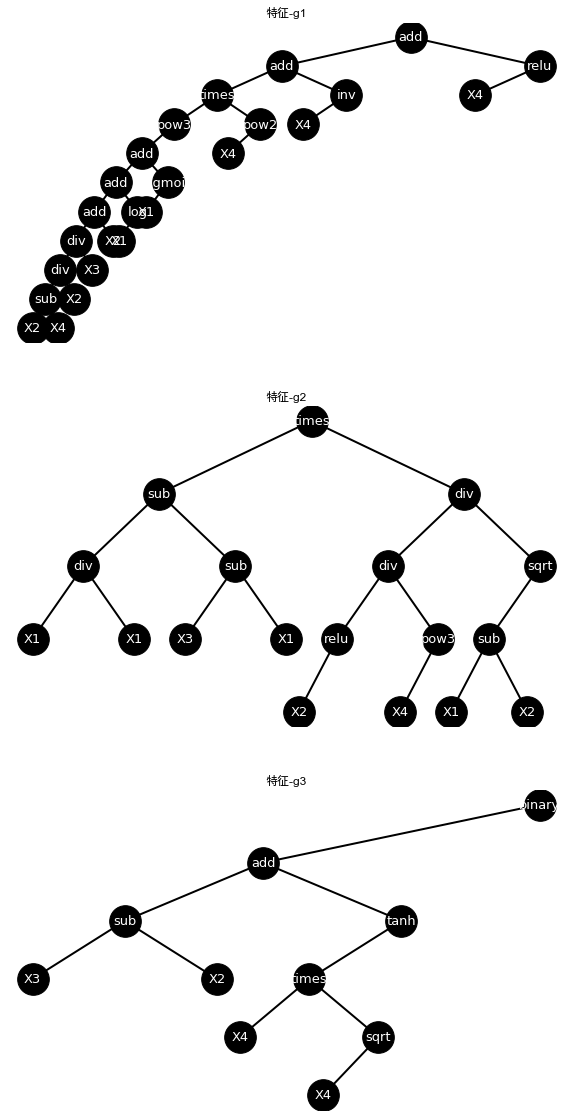

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib
import re

matplotlib.rcParams['font.family'] = 'Arial Unicode MS'
counter = 1
titles=['特征-g1','特征-g2','特征-g3']
plt.figure(figsize=(10,20))
for e in individuals['gene'][loc]:
    plt.subplot(3,1,counter)
    plot_tree(e, title=titles[counter - 1],node_size= 1000,font_size=13)
    counter = counter + 1
plt.show()